In [8]:
import pandas as pd

# Read Data
df = pd.read_csv("data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [9]:
import numpy as np

# Preprocess Data
df = df.drop(columns=["id", "Unnamed: 32"])
X_df = df.drop(columns=["diagnosis"])
y_df = df["diagnosis"]

# Convert to numpy
X = X_df.to_numpy()
y = y_df.to_numpy()

# Scale data
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / std

In [10]:
class GMM:
    def __init__(self, k_components, covariance_type='full'):
        self.k_components = k_components
        self.covariance_type = covariance_type

        self.means = None
        self.covariances = None
        self.weights = None
        self.responsibilities = None

        # Attributes for Experiments
        self.log_likelihoods = []
        self.aic = None
        self.bic = None
        self.labels = None

    def fit(self, X, max_iter=100, tol=1e-6):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.initialize_parameters(X)

        log_likelihood_old = None

        for iteration in range(max_iter):
            # E-step
            self.responsibilities = self.e_step(X)

            # M-step
            self.m_step(X)

            # Compute log likelihood
            log_likelihood_new = self.compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood_new)

            # Check for convergence
            if log_likelihood_old is not None and abs(log_likelihood_new - log_likelihood_old) < tol:
                break
            log_likelihood_old = log_likelihood_new

        # Compute AIC and BIC
        self.compute_aic_bic(X)

        # Assign labels based on responsibilities
        self.labels = np.argmax(self.responsibilities, axis=1)

    def predict(self, X):
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)

    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        random_indices = np.random.choice(n_samples, self.k_components, replace=False)
        self.means = X[random_indices]

        self.weights = np.ones(self.k_components) / self.k_components
        global_cov = np.cov(X, rowvar=False)

        if self.covariance_type == 'full':
            self.covariances = np.array([global_cov for _ in range(self.k_components)])
        elif self.covariance_type == 'tied':
            self.covariances = global_cov
        elif self.covariance_type == 'diag':
            diag = np.diag(global_cov)
            self.covariances = np.array([diag for _ in range(self.k_components)])
        elif self.covariance_type == 'spherical':
            var = np.mean(np.diag(global_cov))
            self.covariances = np.array([var for _ in range(self.k_components)])
    
    def e_step(self, X):
        n_samples, n_features = X.shape
        log_numerators = np.zeros((n_samples, self.k_components))

        for k in range(self.k_components):
            if self.covariance_type == 'full':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'tied':
                cov_k = self.covariances
            elif self.covariance_type == 'diag':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'spherical':
                cov_k = self.covariances[k]
            
            log_likelihood = self.log_gaussian(X, k, cov_k)
            log_numerators[:, k] = np.log(self.weights[k] + 1e-10) + log_likelihood

        a_max = np.max(log_numerators, axis=1, keepdims=True)
        shifted_numerators = log_numerators - a_max
        numerators = np.exp(shifted_numerators)

        denominator = np.sum (numerators, axis=1, keepdims=True)
        responsibilities = numerators / denominator

        return responsibilities 
        
    def log_gaussian(self, X, k, cov):
        mean = self.means[k]
        _, n_features = X.shape

        if self.covariance_type in ['spherical', 'diag']:
            cov_stable = cov + 1e-6

            if self.covariance_type == 'spherical':
                log_det = n_features * np.log(cov_stable)
                inverse = 1.0 / cov_stable
            else:
                log_det = np.sum(np.log(cov_stable))
                inverse = 1.0 / cov_stable

            diff = X - mean
            quadratic_term = np.sum ((diff**2) * inverse, axis = 1)
        
        else:
            cov_stable = cov + np.eye(n_features) * 1e-6

            _, log_det = np.linalg.slogdet(cov_stable)
            inverse = np.linalg.inv(cov_stable)

            diff = X - mean
            quadratic_term = np.sum(np.dot(diff, inverse)*diff, axis=1)
        
        constant = -0.5 * n_features * np.log(2*np.pi)
        return constant - 0.5 * log_det - 0.5 * quadratic_term
    
    def m_step (self, X):
        n_samples, n_features = X.shape

        # Update Weights (PI)
        sum_res = np.sum(self.responsibilities, axis=0)
        self.weights = sum_res / n_samples

        # Update Means
        self.means = np.dot(self.responsibilities.T, X) / sum_res.reshape(-1, 1)

        # Update Covariances
        if self.covariance_type == 'full':
            self.covariances = np.zeros((self.k_components, n_features, n_features))
            for k in range(self.k_components):
                diff = X - self.means[k]
                weighted_diff = self.responsibilities[:, k].reshape(-1, 1) * diff
                self.covariances[k] = np.dot(weighted_diff.T, diff) / sum_res[k]
                self.covariances[k].flat[::n_features + 1] += 1e-6
        
        elif self.covariance_type == 'tied':
            cov = np.zeros((n_features, n_features))
            for k in range(self.k_components):
                diff = X - self.means[k]
                weighted_diff = self.responsibilities[:, k].reshape(-1, 1) * diff
                cov += np.dot(weighted_diff.T, diff)
            self.covariances = cov / n_samples
            self.covariances.flat[::n_features + 1] += 1e-6
        
        elif self.covariance_type == 'diag':
            self.covariances = np.zeros((self.k_components, n_features))
            for k in range(self.k_components):
                diff = X - self.means[k]
                weighted_diff_sq = self.responsibilities[:, k].reshape(-1, 1) * (diff ** 2)
                self.covariances[k] = np.sum(weighted_diff_sq, axis=0) / sum_res[k] + 1e-6
        
        elif self.covariance_type == 'spherical':
            self.covariances = np.zeros(self.k_components)
            for k in range(self.k_components):
                diff = X - self.means[k]
                weighted_diff_sq = self.responsibilities[:, k].reshape(-1, 1) * (diff ** 2)
                self.covariances[k] = np.sum(weighted_diff_sq) / (n_features * sum_res[k]) + 1e-6

    def compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_numerators = np.zeros((n_samples, self.k_components))

        for k in range(self.k_components):
            if self.covariance_type == 'full':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'tied':
                cov_k = self.covariances
            elif self.covariance_type == 'diag':
                cov_k = self.covariances[k]
            elif self.covariance_type == 'spherical':
                cov_k = self.covariances[k]
            
            # Compute log-probability for component k
            log_density = self.log_gaussian(X, k, cov_k)
            log_numerators[:, k] = np.log(self.weights[k] + 1e-10) + log_density

        a_max = np.max(log_numerators, axis=1, keepdims=True)
        return np.sum(a_max + np.log(np.sum(np.exp(log_numerators - a_max), axis=1)))
    
    def compute_aic_bic(self, X):
        n_samples, n_features = X.shape
        log_likelihood = self.log_likelihoods[-1]

        n_params = 0
        # Means parameters (K * D)
        n_params += self.k_components * n_features
        
        # Weights parameters (K - 1)
        n_params += self.k_components - 1

        # Covariance parameters
        if self.covariance_type == 'full':
            # K * (D * (D+1) / 2)
            n_params += self.k_components * n_features * (n_features + 1) // 2
        elif self.covariance_type == 'tied':
            # 1 shared matrix: D * (D+1) / 2
            n_params += n_features * (n_features + 1) // 2
        elif self.covariance_type == 'diag':
            # K * D
            n_params += self.k_components * n_features
        elif self.covariance_type == 'spherical':
            # K
            n_params += self.k_components

        # Compute AIC and BIC
        self.aic = 2 * n_params - 2 * log_likelihood
        self.bic = n_params * np.log(n_samples) - 2 * log_likelihood


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from evaluation import silhouette_score, davies_bouldin_index, calinski_harabasz_index, wcss, adjusted_rand_index, normalized_mutual_info, purity_score

def run_gmm_experiment(X, k_range, cov_types=['full', 'tied', 'diag', 'spherical']):
    results = []
    models = {}
    best_model = None
    for cov_type in cov_types:
        for k in k_range:
            # Initialize and fit model
            gmm = GMM(k_components=k, covariance_type=cov_type)
            gmm.fit(X)

            labels = gmm.labels

            sil = silhouette_score(X, labels)
            db = davies_bouldin_index(X, labels)
            ch = calinski_harabasz_index(X, labels)

            Wcss = wcss(X, labels)

            ari = adjusted_rand_index(y, labels)
            nmi = normalized_mutual_info(y, labels)
            purity = purity_score(y, labels)
            
            # Extract Log Likelihood 
            final_ll = gmm.log_likelihoods[-1]
            
            results.append({
                'k': k,
                'Covariance': cov_type,
                'BIC': gmm.bic,          # Lower is better
                'AIC': gmm.aic,          # Lower is better
                'Log_Likelihood': final_ll, # Higher is better
                'Silhouette': sil,       # Higher is better
                'Davies_Bouldin': db,    # Lower is better
                'Calinski_Harabasz': ch, # Higher is better
                'WCSS': Wcss,             # Lower is better
                
                # External
                'ARI': ari,
                'NMI': nmi,
                'Purity': purity
            })
            
            # Keep track of best model
            '''if best_model == None:
                best_model = gmm
            elif gmm.bic < best_model.bic:
                best_model = gmm'''
            models[(cov_type, k)] = gmm

    df = pd.DataFrame(results)
    return df, models

# Run
k_range = range(4, 12)
df_results, model_dictionary = run_gmm_experiment(X_scaled, k_range)

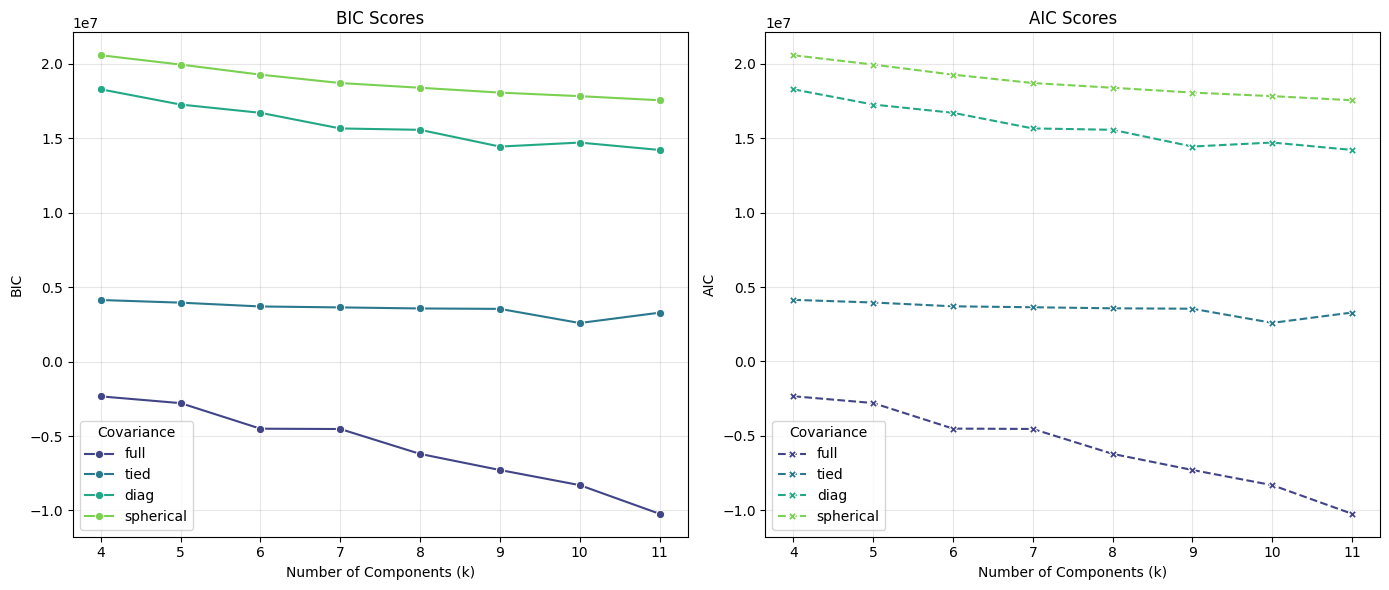

In [12]:
def plot_bic_aic_curves(df_results):
    plt.figure(figsize=(14, 6))

    # Plot 1: BIC
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df_results, x='k', y='BIC', hue='Covariance', marker='o', palette='viridis')
    plt.title('BIC Scores')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('BIC')
    plt.grid(True, alpha=0.3)

    # Plot 2: AIC
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df_results, x='k', y='AIC', hue='Covariance', marker='X', palette='viridis', linestyle='--')
    plt.title('AIC Scores')
    plt.xlabel('Number of Components (k)')
    plt.ylabel('AIC')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run visualization
plot_bic_aic_curves(df_results)

In [13]:
from evaluation import adjusted_rand_index, normalized_mutual_info, purity_score, confusion_matrix
# best Metrics
best_gmm = model_dictionary[('full', 8)]
labels = best_gmm.labels
best_metrics = df_results[
    (df_results['k'] == 8) & 
    (df_results['Covariance'] == 'full')
]

display(best_metrics)

,k,Covariance,BIC,AIC,Log_Likelihood,Silhouette,Davies_Bouldin,Calinski_Harabasz,WCSS,ARI,NMI,Purity
4,8,full,-6.203484e+06,-6.220717e+06,3.114325e+06,0.093817,3.953039,30.329675,12383.517849,0.317343,0.270058,0.864675


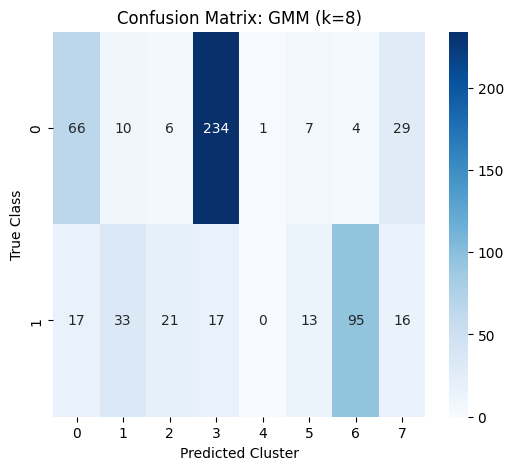

In [14]:
cm = confusion_matrix(y, labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: GMM (k={best_gmm.k_components})')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.show()

In [15]:
import numpy as np
import pandas as pd
from PCA import PCA

def run_pca_gmm_experiment_full(X_scaled, y_true, pca_components_range, k_range, cov_types):
    results = []
    best_models = {} # To store model objects

    # OUTER LOOP: PCA Dimensions
    for n_comp in pca_components_range:
        
        pca = PCA(n_components=n_comp)
        X_pca = pca.compute_pca(X_scaled) 
        
        X_rec = pca.reconstruct(X_pca)
        mse = pca.reconstruction_error(X_scaled, X_rec)

        best_bic_for_dim = float('inf')
        best_gmm_for_dim = None
        best_stats_for_dim = {}

        # INNER LOOP: GMM
        for cov_type in cov_types:
            for k in k_range:
                
                gmm = GMM(k_components=k, covariance_type=cov_type)
                gmm.fit(X_pca)

                if gmm.bic < best_bic_for_dim:
                    best_bic_for_dim = gmm.bic
                    best_gmm_for_dim = gmm
                    
                    sil = silhouette_score(X_pca, gmm.labels)
                    ari = adjusted_rand_index(y_true, gmm.labels)
                    purity = purity_score(y_true, gmm.labels)
                    
                    best_stats_for_dim = {
                        'k': k,
                        'Covariance': cov_type,
                        'BIC': gmm.bic,
                        'AIC': gmm.aic,
                        'Silhouette': sil,
                        'ARI': ari,
                        'Purity': purity
                    }

        # Store the BEST result for this PCA dimension
        if best_gmm_for_dim is not None:
            entry = {
                'n_components': n_comp,
                'MSE': mse,
                **best_stats_for_dim # Unpack the best GMM stats
            }
            results.append(entry)
            best_models[n_comp] = best_gmm_for_dim
            
            print(f" -> PCA={n_comp}: Best GMM was k={entry['k']} ({entry['Covariance']}). Purity={entry['Purity']:.3f}")

    return pd.DataFrame(results), best_models

# Run the Experiment
pca_range = [2, 5, 10, 15, 20]
k_range = range(2, 7)
cov_types = ['full', 'tied', 'diag', 'spherical']

df_pca_results, pca_models = run_pca_gmm_experiment_full(X_scaled, y, pca_range, k_range, cov_types)

 -> PCA=2: Best GMM was k=6 (full). Purity=0.912
 -> PCA=5: Best GMM was k=6 (full). Purity=0.888
 -> PCA=10: Best GMM was k=6 (full). Purity=0.837
 -> PCA=15: Best GMM was k=6 (full). Purity=0.903
 -> PCA=20: Best GMM was k=5 (full). Purity=0.893


In [16]:

def plot_custom_pca_clusters(X, labels, title="Cluster Assignments (Custom PCA)"):
    # Instantiate with 2 components
    pca_2d = PCA(n_components=2)
    
    X_proj = pca_2d.compute_pca(X)
    
    # Get explained variance for axis labels
    variance_ratios = pca_2d.explained_variance()
    x_label = f"PC1 ({variance_ratios[0]:.2%} Variance)"
    y_label = f"PC2 ({variance_ratios[1]:.2%} Variance)"

    plt.figure(figsize=(10, 7))
    
    # Scatter plot
    sns.scatterplot(
        x=X_proj[:, 0], 
        y=X_proj[:, 1], 
        hue=labels, 
        palette='viridis', 
        s=60,              
        alpha=0.7,        
        style=labels      
    )
    plt.title(title, fontsize=15)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Global Winner: PCA Components=2, k=6, Cov=full


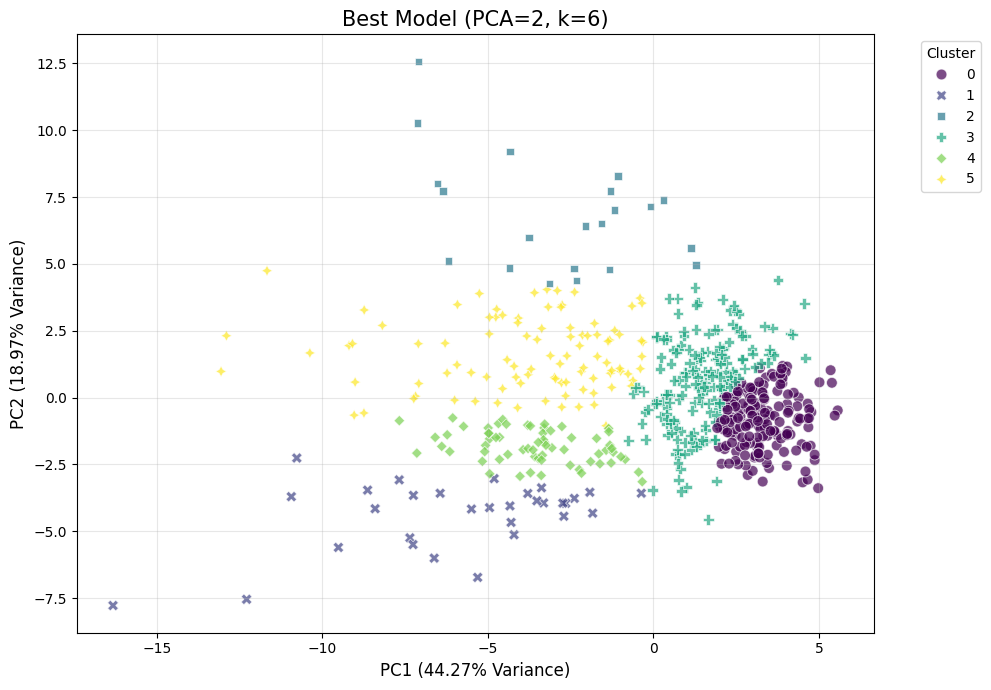

In [17]:
# Find the best dimension from the results (Lowest BIC)
best_row = df_pca_results.loc[df_pca_results['BIC'].idxmin()]
best_n_comp = int(best_row['n_components'])
best_k = int(best_row['k'])

print(f"Global Winner: PCA Components={best_n_comp}, k={best_k}, Cov={best_row['Covariance']}")

final_best_model = pca_models[best_n_comp]

labels = final_best_model.labels

plot_custom_pca_clusters(X_scaled, labels, title=f"Best Model (PCA={best_n_comp}, k={best_k})")

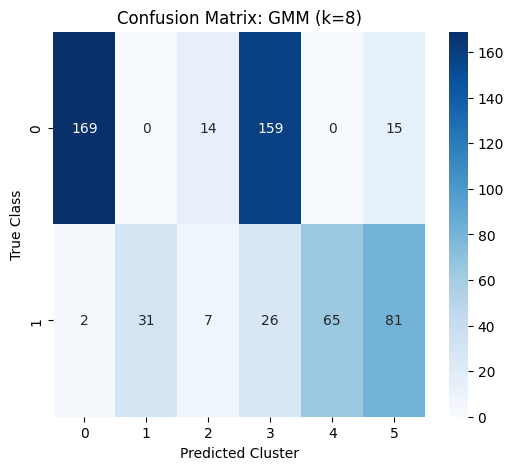

In [18]:
from evaluation import confusion_matrix
cm = confusion_matrix(y, labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: GMM (k={best_gmm.k_components})')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Class')
plt.show()